# Gradcam with Transfer Learning

This is a simple example to show how Gradcam could be used with models that used transfer learning techniques.
The first part of setting up and building the model is just an example and it can be setting up in other ways. The important thing here is apply transfer learning and than use Gradcam on it.

### Setting up 

In [1]:
from gradcam import Gradcam

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

In [2]:

# X = np.load(FOLDER + "224X_save.npy")
# y = np.load(FOLDER + "224y_save.npy")
# print(len(X), len(y))

In [3]:
size = 224
img_size=(size, size)
img_shape = (size, size, 3)
batch_size = 32

### Loading Dataset

In [4]:
# tfds.disable_progress_bar()

# train_ds, validation_ds, test_ds = tfds.load(
#     "cats_vs_dogs",
#     split=[
#        tfds.Split.TRAIN.subsplit(tfds.percent[:10]),
#        tfds.Split.TRAIN.subsplit(tfds.percent[10:13]),
#        tfds.Split.TRAIN.subsplit(tfds.percent[13:16])
#     ],
#     as_supervised=True,  # Include labels
# )

In [5]:
# plt.figure(figsize=(10, 10))
# for i, (image, label) in enumerate(train_ds.take(9)):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(image)
#     plt.title(int(label))
#     plt.axis("off")

In [6]:
# train_ds = train_ds.map(lambda image, label: (tf.image.resize(image, img_size), label))
# validation_ds = validation_ds.map(lambda image, label: (tf.image.resize(image, img_size), label))

# train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
# validation_ds = validation_ds.cache().batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
# data_augmentation = keras.Sequential(
#     [
#         layers.experimental.preprocessing.RandomFlip("horizontal"),
#         layers.experimental.preprocessing.RandomRotation(0.1),
#     ]
# )

### Building Model

In [26]:
def build_model(base_model):
    inputs = layers.Input(shape=img_shape)
    #x = data_augmentation(inputs)
    x = base_model(inputs, training=False)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="softmax", name="pred")(x)

    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")

    return model
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#base_model = InceptionV3(include_top=False, input_shape=img_shape, weights="imagenet")#
#base_model =EfficientNetB0(include_top=False, input_shape=img_shape, weights="imagenet")
# from keras.applications.xception import Xception, preprocess_input
# base_model = Xception(include_top=False, input_shape=img_shape, weights="imagenet")
# xception_preprocessor = preprocess_input

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
base_model = InceptionResNetV2(include_top=False, input_shape=img_shape, weights="imagenet")

base_model.trainable = False
model = build_model(base_model)

# # Compile
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
# loss = keras.losses.SparseCategoricalCrossentropy()
# metrics = keras.metrics.SparseCategoricalAccuracy()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

model.summary()

Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 avg_pool (GlobalAveragePool  (None, 1536)             0         
 ing2D)                                                          
                                                                 
 batch_normalization_309 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 top_dropout (Dropout)       (None, 1536)              0         
                                                    

In [29]:
model.get_layer('inception_resnet_v2').summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 111, 111, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_106 (Batch  (None, 111, 111, 32  96         ['conv2d_102[0][0]']             
 Normalization)                 )                                               

In [10]:
X = np.load("./X_save.npy")
y = np.load("./y_save.npy")

from keras.callbacks import EarlyStopping
#Prepare call backs
EarlyStop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
my_callback=[EarlyStop_callback]

# train_ds = [X[:4000], y[:4000]]
# validation_ds = [X[4000:4500], y[4000:4500]]

model.fit(X[:4000],  y[:4000],
            batch_size=128,
            epochs=10,
            validation_split=0.1,
            callbacks=my_callback)

Epoch 1/10
29/29 [==============================] - 66s 2s/step - loss: 5.7663 - accuracy: 0.0197 - val_loss: 7.4058 - val_accuracy: 0.0525
Epoch 2/10
29/29 [==============================] - 65s 2s/step - loss: 4.9100 - accuracy: 0.0503 - val_loss: 6.0471 - val_accuracy: 0.0300
Epoch 3/10
29/29 [==============================] - 62s 2s/step - loss: 4.4350 - accuracy: 0.0822 - val_loss: 5.5390 - val_accuracy: 0.0550
Epoch 4/10
29/29 [==============================] - 63s 2s/step - loss: 4.1312 - accuracy: 0.1147 - val_loss: 5.4378 - val_accuracy: 0.0525
Epoch 5/10
29/29 [==============================] - 62s 2s/step - loss: 3.8487 - accuracy: 0.1461 - val_loss: 5.2843 - val_accuracy: 0.0400
Epoch 6/10
29/29 [==============================] - 62s 2s/step - loss: 3.6142 - accuracy: 0.1767 - val_loss: 5.2797 - val_accuracy: 0.0425
Epoch 7/10
29/29 [==============================] - 63s 2s/step - loss: 3.4169 - accuracy: 0.2136 - val_loss: 5.2757 - val_accuracy: 0.0450
Epoch 8/10
29/29 [==

### Gradcam

In [30]:
%matplotlib agg
%matplotlib agg

img_path = "../images/example.jpg"

gc = Gradcam(model, 
             layer_name="conv_7b",
             img_path=img_path,
             size=img_size,
             inner_model=model.get_layer("inception_resnet_v2"))

# gc = Gradcam(model, 
            #  layer_name="top_conv",
            #  img_path=img_path,
            #  size=img_size,
            #  inner_model=model.get_layer("efficientnetb0"))

gc.generate_stack_img(save_name="../output/example_out")

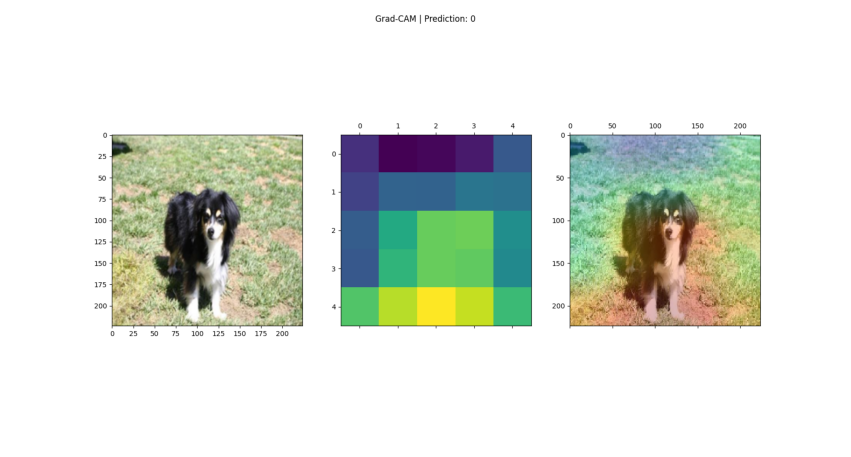

In [31]:
%matplotlib inline

output = mpimg.imread('../output/example_out.png')
fig, ax = plt.subplots(figsize=(15,10))
plt.axis("off")
plt.imshow(output)